# Quora Question Pair Similarity

# 1. Business Problem:
<p>Quora is a place to gain and share knowledge—about anything. It’s a platform to ask questions and connect with people who contribute unique insights and quality answers. This empowers people to learn from each other and to better understand the world.</p>
<p>
Over 100 million people visit Quora every month, so it's no surprise that many people ask similarly worded questions. Multiple questions with the same intent can cause seekers to spend more time finding the best answer to their question, and make writers feel they need to answer multiple versions of the same question. Quora values canonical questions because they provide a better experience to active seekers and writers, and offer more value to both of these groups in the long term.
</p>
<br>
> Credits: Kaggle 

__ Problem Statement __
- Identify which questions asked on Quora are duplicates of questions that have already been asked. 
- This could be useful to instantly provide answers to questions that have already been answered. 
- We are tasked with predicting whether a pair of questions are duplicates or not. 

- Source : https://www.kaggle.com/c/quora-question-pairs

### Real world/Business Objectives and Constraints
1. The cost of a mis-classification can be very high.
2. You would want a probability of a pair of questions to be duplicates so that you can choose any threshold of choice.
3. No strict latency concerns.
4. Interpretability is partially important.

# 2. Machine Learning Problem

In [2]:
# Lets import all the necessary libraries
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
%matplotlib inline

## Exploratory Data Analysis.

In [8]:
# Lets import the data from kaggle api
!kaggle competitions download -c quora-question-pairs


  0%|          | 0.00/4.95M [00:00<?, ?B/s]
100%|##########| 4.95M/4.95M [00:00<00:00, 166MB/s]

  0%|          | 0.00/21.2M [00:00<?, ?B/s]
 43%|####2     | 9.00M/21.2M [00:00<00:00, 50.3MB/s]
100%|##########| 21.2M/21.2M [00:00<00:00, 71.0MB/s]

  0%|          | 0.00/112M [00:00<?, ?B/s]
 11%|#         | 12.0M/112M [00:00<00:00, 115MB/s]
 20%|##        | 23.0M/112M [00:00<00:00, 112MB/s]
 36%|###6      | 41.0M/112M [00:00<00:00, 89.1MB/s]
 56%|#####6    | 63.0M/112M [00:00<00:00, 108MB/s] 
 75%|#######4  | 84.0M/112M [00:00<00:00, 125MB/s]
 96%|#########6| 108M/112M [00:00<00:00, 145MB/s] 
100%|##########| 112M/112M [00:00<00:00, 135MB/s]


In [3]:
df = pd.read_csv('train.csv')
final_test_df = pd.read_csv('test.csv')

In [4]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


#### Data Description:
- id - the id of a training set question pair
- qid1, qid2 - unique ids of each question (only available in train.csv)
- question1, question2 - the full text of each question
- is_duplicate - the target variable, set to 1 if question1 and question2 have essentially the same meaning, and 0 otherwise.
- Source: https://www.kaggle.com/c/quora-question-pairs/data

In [5]:
final_test_df.head()

,test_id,question1,question2
0,0,How does the Surface Pro himself 4 compare wit...,Why did Microsoft choose core m3 and not core ...
1,1,Should I have a hair transplant at age 24? How...,How much cost does hair transplant require?
2,2,What but is the best way to send money from Ch...,What you send money to China?
3,3,Which food not emulsifiers?,What foods fibre?
4,4,"How ""aberystwyth"" start reading?",How their can I start reading?


- As in the data descripiton, fianl test set only contains test_id, question1 and question2 features.

#### Type of Machine learning problem.

In [6]:
np.unique(df.is_duplicate)

array([0, 1], dtype=int64)

- From above we can see that the target variable either contains 0 or 1 indication whether the question pairs are duplicate or not.
- So the machine learning problem we are trying to solve is a binary classification Problem.

#### Performance Metric:
Kaggle has given log loss as performance metric to this problem and we are taking the same log loss as a performance metric to this problem.
- Source: https://www.kaggle.com/c/quora-question-pairs/overview/evaluation

- Also we will consider binary confusion matrix to understand better. 

In [7]:
df.shape

(404290, 6)

- So there are total 404290 observations

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404290 entries, 0 to 404289
Data columns (total 6 columns):
id              404290 non-null int64
qid1            404290 non-null int64
qid2            404290 non-null int64
question1       404290 non-null object
question2       404288 non-null object
is_duplicate    404290 non-null int64
dtypes: int64(4), object(2)
memory usage: 18.5+ MB


- Dataset given is pretty clean except 2 null values in the the question2.
- The number of features given are also very small only 6, We may need to create features based on the data if necessary.

In [9]:
# Lets see the distribution of class variables
df.is_duplicate.value_counts(normalize=True)

0    0.630802
1    0.369198
Name: is_duplicate, dtype: float64

- So the percentage of duplicate question pairs are 63.08
- and the percentage of non duplicate question pairs are 36.91 

In [10]:
df.head()

,id,qid1,qid2,question1,question2,is_duplicate
0,0,1,2,What is the step by step guide to invest in sh...,What is the step by step guide to invest in sh...,0
1,1,3,4,What is the story of Kohinoor (Koh-i-Noor) Dia...,What would happen if the Indian government sto...,0
2,2,5,6,How can I increase the speed of my internet co...,How can Internet speed be increased by hacking...,0
3,3,7,8,Why am I mentally very lonely? How can I solve...,Find the remainder when [math]23^{24}[/math] i...,0
4,4,9,10,"Which one dissolve in water quikly sugar, salt...",Which fish would survive in salt water?,0


In [11]:
# lets see the number of unique questions
total_qids = pd.Series(df.qid1.tolist() + df.qid2.tolist())
np.unique(total_qids)

array([     1,      2,      3, ..., 537931, 537932, 537933], dtype=int64)

In [12]:
print(f"so there are total {len(np.unique(total_qids))} unique questions present")

so there are total 537933 unique questions present


In [13]:
qs_more_than_once = np.sum(total_qids.value_counts() > 1)
print(f"questions that appeared more than once are {qs_more_than_once}")
print(f"max number of times a single question appeared is {total_qids.value_counts().max()}")

questions that appeared more than once are 111780
max number of times a single question appeared is 157


In [20]:
total_qids.value_counts().max()

157

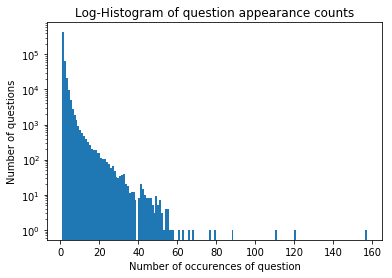

In [30]:
# Lets see the occurencess of questions
plt.hist(total_qids.value_counts(), bins=160);
plt.yscale('log', nonposy='clip')
plt.title('Log-Histogram of question appearance counts');

plt.xlabel('Number of occurences of question');

plt.ylabel('Number of questions');

In [15]:
(total_qids.value_counts() > 1).value_counts(normalize=True)

False    0.792205
True     0.207795
dtype: float64

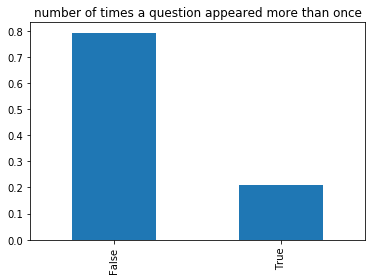

In [16]:
(total_qids.value_counts() > 1).value_counts(normalize=True).plot('bar');
plt.title("number of times a question appeared more than once");

- So 79.22% questions never appeared more than once
- while 20.77% questions have appeared more than once

#### Check for Duplicates and null values:

In [52]:
df.duplicated(['qid1','qid2']).sum()

0

- So there are no duplicates

In [33]:
df.isnull().sum()

id              0
qid1            0
qid2            0
question1       0
question2       2
is_duplicate    0
dtype: int64

- So there are two null values in question2, Lets see it further

In [37]:
df.question2[df.question2.isnull()]

105780    NaN
201841    NaN
Name: question2, dtype: object

In [38]:
df.loc[105780]

id                                      105780
qid1                                    174363
qid2                                    174364
question1       How can I develop android app?
question2                                  NaN
is_duplicate                                 0
Name: 105780, dtype: object

In [39]:
df.loc[201841]

id                                        201841
qid1                                      303951
qid2                                      174364
question1       How can I create an Android app?
question2                                    NaN
is_duplicate                                   0
Name: 201841, dtype: object

In [40]:
# As we can see quesiton with id2 has null value
# Lets see how all the data related to question id2
df[df.qid2==174364]

,id,qid1,qid2,question1,question2,is_duplicate
105780,105780,174363,174364,How can I develop android app?,NaN,0
201841,201841,303951,174364,How can I create an Android app?,NaN,0


- As wee can see qid2 with id 174364 is present 2 times both with null values Lets drop the 2 observations from our dataframe

In [43]:
df = df.drop([105780, 201841])